<a href="https://colab.research.google.com/github/Bobbyorr007/Fashion-MNIST-using-custom-training-loops/blob/main/Fashion_MNIST_using_Custom_Training_Loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Fashion MNIST using Custom Training Loop**

I built a custom training loop and a validation loop so as to train a model on the Fashion MNIST datasets.

**Imports**

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds
import matplotlib.ticker as mticker

**LOAD THE DATASET**

I loaded the Fashion MNIST dataset using Tensorflow Datasets. This dataset has 28 x 28 grayscale images of articles of clothing belonging to 10 clases.

Here you are going to use the training and testing splits of the data. Testing split will be used for validation.

In [2]:
train_data, info = tfds.load("fashion_mnist", split = "train", with_info = True, data_dir='/content/sample_data', download=True)
test_data = tfds.load("fashion_mnist", split = "test", data_dir='/content/sample_data', download=True)

In [3]:
class_names = ["T-shirt/top", "Trouser/pants", "Pullover shirt", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

I normalized the image by dividing them by 255.0 so as to make the pixels fall in the range (0,1). I also reshaped the data so as to flatten the 28*28 pixel array into a flattened 784 pixel array.


In [4]:
def format_image(data):        
    image = data["image"]
    image = tf.reshape(image, [-1])
    image = tf.cast(image, 'float32')
    image = image / 255.0
    return image, data["label"]

In [5]:
train_data = train_data.map(format_image)
test_data = test_data.map(format_image)

I shuffled and batched my training data before feeding it into my model.

The reason we shuffle the train data is that during training, we dont want a repetition of learned weights in different batches.

In [6]:
batch_size = 64
train = train_data.shuffle(buffer_size=1024).batch(batch_size)

test =  test_data.batch(batch_size=batch_size)

**DEFINE THE MODEL**

I used keras functional API to connect two dense layers. The final layer is a softmax that outputs one of the 10 classes since this is a multi class classification problem.

In [7]:
def base_model():
  inputs = tf.keras.Input(shape=(784,), name='digits')
  x = tf.keras.layers.Dense(64, activation='relu', name='dense_1')(inputs)
  x = tf.keras.layers.Dense(64, activation='relu', name='dense_2')(x)
  outputs = tf.keras.layers.Dense(10, activation='softmax', name='predictions')(x)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

**Define Optimizer and Loss Function**

I used Adam Optimizer and Sparse Categorical Crossentropy loss for this example.


In [8]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

**DEFINE METRICS**

I also defined metrics so that my training loop can update and display them. I used the SparseCategoricalAccuracy defined in tf.keras.metrics since the problem at hand is a multiclass classfication problem.

In [9]:
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

**BUILDING TRAINING LOOPS**

In this section I built my training loop consisting of training and validation sequences.

The core of the training is using the model to calculate logits(predicted outputs) on specific set of inputs and compute loss(in this case I used SparseCategoricalCrossentropy)by comparing the predicted outputs to the true outputs. I then update the trainable weights using the chosen optimizer algorithm. Note that the Optimizer needs the computed loss and partial derivatives of loss with respect to each of the trainable weights to make updates to the same.

I used gradient tape to calculate the gradient and updated the models trainable weights with the optimizer. 

In [10]:
def apply_gradient(optimizer, model, x, y):
  with tf.GradientTape() as tape:
    logits = model(x)
    loss_value = loss_object(y_true=y, y_pred=logits)
  
  gradients = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))
  
  return logits, loss_value

This function performs training during one epoch. You run through all batches of training data in each epoch to make updates to trainable weights using your previous function. You can see that we also call update_state on your metrics to accumulate the value of your metrics. You are displaying a progress bar to indicate completion of training in each epoch. Here you use tqdm for displaying the progress bar.

In [11]:
def train_data_for_one_epoch():
  losses = []
  pbar = tqdm(total=len(list(enumerate(train))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
  for step, (x_batch_train, y_batch_train) in enumerate(train):
      logits, loss_value = apply_gradient(optimizer, model, x_batch_train, y_batch_train)
      
      losses.append(loss_value)
      
      train_acc_metric(y_batch_train, logits)
      pbar.set_description("Training loss for step %s: %.4f" % (int(step), float(loss_value)))
      pbar.update()
  return losses

At the end of each epoch you have to validate the model on the test dataset. The following function calculates the loss on test dataset and updates the states of the validation metrics.

In [12]:
def perform_validation():
  losses = []
  for x_val, y_val in test:
      val_logits = model(x_val)
      val_loss = loss_object(y_true=y_val, y_pred=val_logits)
      losses.append(val_loss)
      val_acc_metric(y_val, val_logits)
  return losses

I defined the traning loop thet runs though the training samples repeatedly over a fixed number of epochs. I combined the functions I built early to establish the following flow:

1. Perform training over all batches of training data.
2. Get values of metrics.
3. Perform validation to calculate loss and update validation metrics on test data.
4. Reset the metrics at the end of the epoch.
5. Display statistics at the end of the epoch.

Note: I also calculated the training and validation losses for the whole epoch at the end of the epoch.

In [13]:

model = base_model()

# Iterate over epochs.
epochs = 10
epochs_val_losses, epochs_train_losses = [], []
for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))
  
  losses_train = train_data_for_one_epoch()
  train_acc = train_acc_metric.result()

  losses_val = perform_validation()
  val_acc = val_acc_metric.result()

  losses_train_mean = np.mean(losses_train)
  losses_val_mean = np.mean(losses_val)
  epochs_val_losses.append(losses_val_mean)
  epochs_train_losses.append(losses_train_mean)

  print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f' % (epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc)))
  
  train_acc_metric.reset_states()
  val_acc_metric.reset_states()




Start of epoch 0


Training loss for step 937: 0.6234: 100%|██████████| 938/938 



 Epoch 0: Train loss: 0.5409  Validation Loss: 0.4332, Train Accuracy: 0.8078, Validation Accuracy 0.8455
Start of epoch 1


Training loss for step 937: 0.3405: 100%|██████████| 938/938 



 Epoch 1: Train loss: 0.3855  Validation Loss: 0.4116, Train Accuracy: 0.8610, Validation Accuracy 0.8579
Start of epoch 2


Training loss for step 937: 0.3556: 100%|██████████| 938/938 



 Epoch 2: Train loss: 0.3480  Validation Loss: 0.3796, Train Accuracy: 0.8746, Validation Accuracy 0.8641
Start of epoch 3


Training loss for step 937: 0.1182: 100%|██████████| 938/938 



 Epoch 3: Train loss: 0.3253  Validation Loss: 0.3803, Train Accuracy: 0.8805, Validation Accuracy 0.8693
Start of epoch 4


Training loss for step 937: 0.3140: 100%|██████████| 938/938 



 Epoch 4: Train loss: 0.3065  Validation Loss: 0.3598, Train Accuracy: 0.8875, Validation Accuracy 0.8752
Start of epoch 5


Training loss for step 937: 0.3217: 100%|██████████| 938/938 



 Epoch 5: Train loss: 0.2932  Validation Loss: 0.3503, Train Accuracy: 0.8920, Validation Accuracy 0.8816
Start of epoch 6


Training loss for step 937: 0.1624: 100%|██████████| 938/938 



 Epoch 6: Train loss: 0.2823  Validation Loss: 0.3511, Train Accuracy: 0.8951, Validation Accuracy 0.8807
Start of epoch 7


Training loss for step 937: 0.2482: 100%|██████████| 938/938 



 Epoch 7: Train loss: 0.2703  Validation Loss: 0.3679, Train Accuracy: 0.9008, Validation Accuracy 0.8735
Start of epoch 8


Training loss for step 937: 0.1356: 100%|██████████| 938/938 



 Epoch 8: Train loss: 0.2617  Validation Loss: 0.3432, Train Accuracy: 0.9041, Validation Accuracy 0.8834
Start of epoch 9


Training loss for step 937: 0.1843: 100%|██████████| 938/938 



 Epoch 9: Train loss: 0.2546  Validation Loss: 0.3483, Train Accuracy: 0.9054, Validation Accuracy 0.8818


**EVALUATE MODEL**

PLOTS FOR EVALUATION

I plotted the progress of loss as training proceeds over the number of epochs.


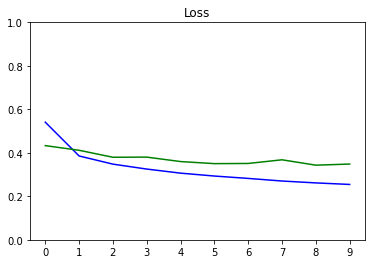

In [14]:
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
  plt.plot(train_metric,color='blue',label=metric_name)
  plt.plot(val_metric,color='green',label='val_' + metric_name)

plot_metrics(epochs_train_losses, epochs_val_losses, "Loss", "Loss", ylim=1.0)

This function displays a row of images with their predictions and true labels.

In [15]:
# utility to display a row of images with their predictions and true labels
def display_images(image, predictions, labels, title, n):

  display_strings = [str(i) + "\n\n" + str(j) for i, j in zip(predictions, labels)] 

  plt.figure(figsize=(17,3))
  plt.title(title)
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], display_strings)
  plt.grid(None)
  image = np.reshape(image, [n, 28, 28])
  image = np.swapaxes(image, 0, 1)
  image = np.reshape(image, [28, 28*n])
  plt.imshow(image)

I made predictions on the test dataset and plot the images with their true and predicted values.

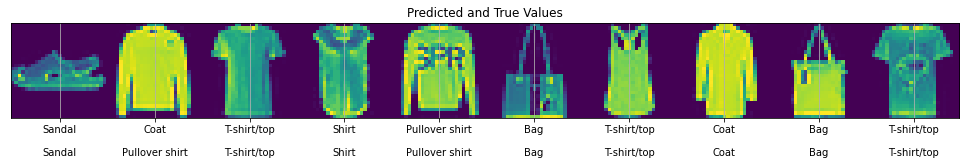

In [16]:
test_inputs = test_data.batch(batch_size=1000001)
x_batches, y_pred_batches, y_true_batches = [], [], []

for x, y in test_inputs:
  y_pred = model(x)
  y_pred_batches = y_pred.numpy()
  y_true_batches = y.numpy()
  x_batches = x.numpy()

indexes = np.random.choice(len(y_pred_batches), size=10)
images_to_plot = x_batches[indexes]
y_pred_to_plot = y_pred_batches[indexes]
y_true_to_plot = y_true_batches[indexes]

y_pred_labels = [class_names[np.argmax(sel_y_pred)] for sel_y_pred in y_pred_to_plot]
y_true_labels = [class_names[sel_y_true] for sel_y_true in y_true_to_plot]
display_images(images_to_plot, y_pred_labels, y_true_labels, "Predicted and True Values", 10)